# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: CatBoost Training

***

**What is the objective of this file?**

To train the model using the Train Split (Statically Split).

## Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. CatB Training Setup

Setting training environment parameters.

## 1.0. Tuning Settings

1. What will the output filename be?
2. Will you train a tuned model?
3. What hyperparameter values will you use?

For no. 3, the value looks like
`{'task_type': 'CPU', 'objective': 'Logloss', 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered', 'auto_class_weights': 'Balanced'}`
which is obtained as part of the results of the associated tuning file to this file.

Alternatively, you can just point a file directly to it (overrides the manual setup if not empty).

**Do not include the custom hyperparameter values for `random_state`, `thread_count`, `verbose`, `cat_features`, and `nan_mode` as the values for these are hardcoded to the notebook.**

In [1]:
MODEL_FILENAME = "RYZEN3b" # <== Set the prefix for the filename of the output file (don't include file extension)
TUNED_TRAINING = False # <== Set as True if you'll be training a tuned model.

# These parameters are mostly default valued parameters for CatBoost except some that are mentioned in the paper (e.g., Ordered Boosting, Symmeteric Tree); Set as None for truly defaults.
TB_HYPERPARAMS = None # None or like "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"
IB_HYPERPARAMS = None # None or like "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"

TB_HYPERPARAMS_FILE = "./Outputs/CATB/Tuning/Manual/RYZEN3b_CATB_TB.tune" # <== Empty string or Pointing a .tune file overrides the value set above.
IB_HYPERPARAMS_FILE = "./Outputs/CATB/Tuning/Manual/RYZEN3b_CATB_IB.tune" # <== Empty string or Pointing a .tune file overrides the value set above.

STATIC_SPLIT = 0.3 # <== To achieve the 70:30 Static Split
RANDOM_SEED = 1 # <== Must be the same throughout the entire study (acts as a controlled variable), hence let's just settle with 1.

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries

In [2]:
#Python Libraries
import time
from datetime import datetime
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
# import lightgbm
import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

## 1.2. Logging and Diagnostics

In [3]:
if TUNED_TRAINING:
    MODEL_FILENAME = "TUNED_" + MODEL_FILENAME
    if len(TB_HYPERPARAMS_FILE) != 0:
        f = open(TB_HYPERPARAMS_FILE, "r")
        TB_HYPERPARAMS = f.readline()
        f.close()
    if len(IB_HYPERPARAMS_FILE) != 0:
        f = open(IB_HYPERPARAMS_FILE, "r")
        IB_HYPERPARAMS = f.readline()
        f.close()
    TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    print("Parsed TB Hyperparams:", TB_HYPERPARAMS)
    print("")
    IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    print("Parsed IB Hyperparams:", IB_HYPERPARAMS)
else:
    if TB_HYPERPARAMS != None:
        TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    else:
        TB_HYPERPARAMS = None
    if IB_HYPERPARAMS != None:
        IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    else:
        IB_HYPERPARAMS = None

start = end = 0
LOG_FILENAME = "CATB_Training_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{MODEL_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

## 1.3. Loading Datasets

Note that it will use the files in `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 

### 1.3.1. Setting filenames

In [4]:
#Setting filenames of files
TB_Train = "../Dataset/TB/CATB_TB.csv" # <== Location for Time-based Train Split for CatBoost
#TB_Test = "../Dataset/TB/TB_Test_CATB.csv" # <== Location for Time-based Test Split for CatBoost
IB_Train = "../Dataset/IB/CATB_IB.csv" # <== Location for Instance-based Train Split for CatBoost
#IB_Test = "../Dataset/IB/IB_Test_CATB.csv" # <== Location for Instance-based Test Split for CatBoost

### 1.3.2. Loading datasets to DataFrames

In [5]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (72298, 101)
IB Train Size: (72298, 101)


### 1.3.3. Previewing datasets

In [6]:
#Previewing Time-based Dataset
tb_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,LdrGetProcedureAddress,GetSystemWindowsDirectoryW,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,GetSystemMetrics,NtAllocateVirtualMemory,CreateActCtxW,GetSystemWindowsDirectoryW
1,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegQueryInfoKeyW,RegEnumKeyExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW
2,1,GetSystemTimeAsFileTime,NtCreateMutant,GetSystemTimeAsFileTime,NtOpenKeyEx,NtQueryKey,NtOpenKeyEx,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExW,...,GetSystemInfo,NtClose,NtUnmapViewOfSection,NtClose,RegOpenKeyExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,NtOpenFile
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW
4,1,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,NtCreateMutant,GetNativeSystemInfo,GetSystemWindowsDirectoryW,NtClose,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll


In [7]:
#Previewing Instance-based Dataset
ib_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,GetSystemTimeAsFileTime,NtCreateMutant,NtOpenKeyEx,NtQueryKey,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExW,RegQueryInfoKeyW,RegEnumKeyExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,NtOpenSection,NtMapViewOfSection,RegOpenKeyExW,RegQueryValueExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.4. Statically Splitting the Train Split

Train Split --> Training and Validation Split

However only Training Split will be used.

In [8]:
X_tb = tb_train.iloc[:,1:101] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only
X_ib = ib_train.iloc[:,1:101] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only

if STATIC_SPLIT > 0:
    X_tb_training, X_tb_validate, y_tb_training, y_tb_validate = train_test_split(X_tb, y_tb, test_size=STATIC_SPLIT, shuffle=True, random_state=1)
    X_ib_training, X_ib_validate, y_ib_training, y_ib_validate = train_test_split(X_ib, y_ib, test_size=STATIC_SPLIT, shuffle=True, random_state=1)
else:
    X_tb_training, y_tb_training = X_tb, y_tb
    X_ib_training, y_ib_training = X_ib, y_ib

# 2. Model Training

## 2.1. Setting up the Model

In [9]:
def get_indexes():
    indexes = []
    for i in range(100):
        indexes.append(f"t_{i}")
    return indexes

def setup_model(HYPERPARAMS, TYPE):
    global TUNED_TRAINING
    indexes = get_indexes()
    metric=['Logloss', 'AUC', 'Precision']
    train_dir = f"Outputs/CATB/{MODEL_FILENAME}_CATB_{TYPE}_TRAINDIR"
    if HYPERPARAMS == None:
        return catboost.CatBoostClassifier(random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, 
                                           nan_mode='Min', custom_metric=metric, train_dir=train_dir, one_hot_max_size=256)
    return catboost.CatBoostClassifier(**HYPERPARAMS, random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, 
                                       nan_mode='Min', custom_metric=metric, train_dir=train_dir, one_hot_max_size=256)

## 2.2. Training on Time-Based Behaviors

### 2.2.1 Training Model

In [10]:
#Training Model
start_time()
tb_catb = setup_model(TB_HYPERPARAMS, "TB")
if STATIC_SPLIT > 0:
    tb_catb.fit(X_tb_training, y_tb_training, plot=True, eval_set=catboost.Pool(X_tb_validate, label=y_tb_validate, cat_features=get_indexes()), save_snapshot=True, snapshot_interval=60)
else:
    tb_catb.fit(X_tb_training, y_tb_training)
end_time("CATB_TB")

#Saving Model as file
tb_catb.save_model("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.083532

bestTest = 0.02075275634
bestIteration = 424

Shrink model to first 425 iterations.


### 2.2.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

CATB_TB
              precision    recall  f1-score   support

           0     0.9993    0.9904    0.9949     10842
           1     0.9905    0.9994    0.9949     10848

    accuracy                         0.9949     21690
   macro avg     0.9949    0.9949    0.9949     21690
weighted avg     0.9949    0.9949    0.9949     21690

AUC-ROC: 0.9948811968124615


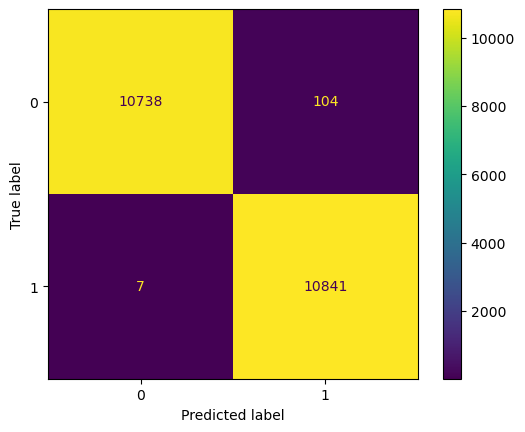

In [11]:
if STATIC_SPLIT > 0:
    y_pred = tb_catb.predict(X_tb_validate)
    print("CATB_TB")
    print(classification_report(y_tb_validate, y_pred, digits=4))
    print("AUC-ROC:", roc_auc_score(y_tb_validate, y_pred))
    print(classification_report(y_tb_validate, y_pred, digits=4), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB_ClassReport.txt", mode='w'))
    print("AUC-ROC:", roc_auc_score(y_tb_validate, y_pred), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB_ClassReport.txt", mode='a'))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_tb_validate, y_pred))
    disp.plot()
    plt.savefig("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB_"+"_ConfMatrix.png")

### 2.2.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

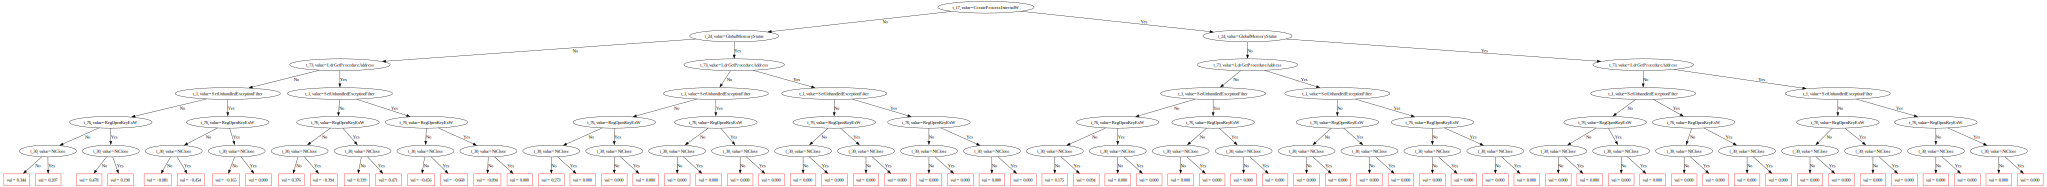

In [12]:
tree = tb_catb.plot_tree(0, catboost.Pool(X_tb_training, y_tb_training, cat_features=get_indexes(), feature_names=list(X_tb_training.columns)))
tree.save("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TREE/TB_Tree_0"+".svg")
display(tree)

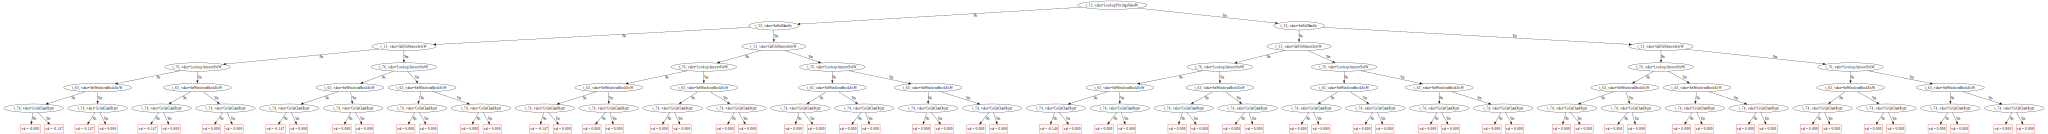

In [13]:
tree = tb_catb.plot_tree(int((tb_catb.get_best_iteration()-1)/2), catboost.Pool(X_tb_training, y_tb_training, cat_features=get_indexes(), feature_names=list(X_tb_training.columns)))
tree.save("Outputs/CATB/"+MODEL_FILENAME+f"_CATB_TREE/TB_Tree_{int((tb_catb.get_best_iteration()-1)/2)}"+".svg")
display(tree)

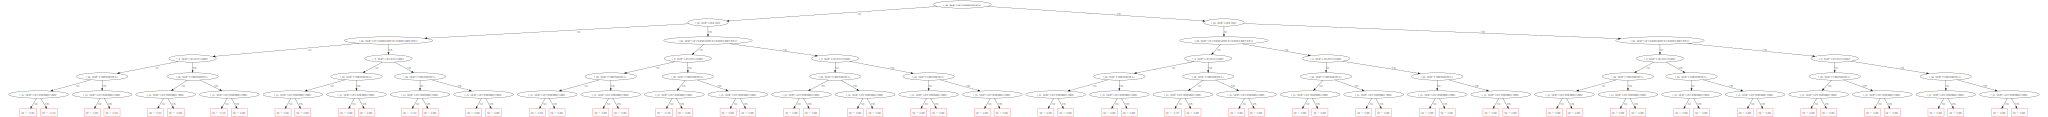

In [14]:
tree = tb_catb.plot_tree(int((tb_catb.get_best_iteration()-1)), catboost.Pool(X_tb_training, y_tb_training, cat_features=get_indexes(), feature_names=list(X_tb_training.columns)))
tree.save("Outputs/CATB/"+MODEL_FILENAME+f"_CATB_TREE/TB_Tree_{int((tb_catb.get_best_iteration()-1))}"+".svg")
display(tree)

## 2.3. Training on Instance-Based Behaviors

### 2.3.1 Training Model

In [15]:
#Training Model
start_time()
ib_catb = setup_model(IB_HYPERPARAMS, "IB")
if STATIC_SPLIT > 0:
    ib_catb.fit(X_ib_training, y_ib_training, plot=True, eval_set=catboost.Pool(X_ib_validate, label=y_ib_validate, cat_features=get_indexes()), save_snapshot=True, snapshot_interval=60)
else:
    ib_catb.fit(X_ib_training, y_ib_training)
end_time("CATB_IB")

#Saving Model as file
ib_catb.save_model("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.083532
0:	learn: 0.5342092	test: 0.5346779	best: 0.5346779 (0)	total: 156ms	remaining: 2m 36s
1:	learn: 0.3912467	test: 0.3919154	best: 0.3919154 (1)	total: 177ms	remaining: 1m 28s
2:	learn: 0.2969116	test: 0.2972638	best: 0.2972638 (2)	total: 199ms	remaining: 1m 6s
3:	learn: 0.2315717	test: 0.2323334	best: 0.2323334 (3)	total: 221ms	remaining: 55.1s
4:	learn: 0.1856561	test: 0.1866744	best: 0.1866744 (4)	total: 243ms	remaining: 48.4s
5:	learn: 0.1517244	test: 0.1528914	best: 0.1528914 (5)	total: 263ms	remaining: 43.5s
6:	learn: 0.1277909	test: 0.1290078	best: 0.1290078 (6)	total: 283ms	remaining: 40.2s
7:	learn: 0.1102311	test: 0.1115369	best: 0.1115369 (7)	total: 304ms	remaining: 37.6s
8:	learn: 0.0980510	test: 0.0994652	best: 0.0994652 (8)	total: 323ms	remaining: 35.6s
9:	learn: 0.0863177	test: 0.0879686	best: 0.0879686 (9)	total: 343ms	remaining: 33.9s
10:	learn: 0.0729704	test: 0.0746957	best: 0.0746957 (10)	total: 363ms	remaining: 32.6s
11:	learn: 0.0633827

95:	learn: 0.0258368	test: 0.0311337	best: 0.0311337 (95)	total: 1.92s	remaining: 18s
96:	learn: 0.0258099	test: 0.0311424	best: 0.0311337 (95)	total: 1.93s	remaining: 18s
97:	learn: 0.0257815	test: 0.0311349	best: 0.0311337 (95)	total: 1.95s	remaining: 18s
98:	learn: 0.0257552	test: 0.0311351	best: 0.0311337 (95)	total: 1.97s	remaining: 17.9s
99:	learn: 0.0254791	test: 0.0308837	best: 0.0308837 (99)	total: 1.99s	remaining: 17.9s
100:	learn: 0.0254333	test: 0.0308400	best: 0.0308400 (100)	total: 2s	remaining: 17.8s
101:	learn: 0.0253966	test: 0.0308007	best: 0.0308007 (101)	total: 2.02s	remaining: 17.8s
102:	learn: 0.0253718	test: 0.0307890	best: 0.0307890 (102)	total: 2.04s	remaining: 17.7s
103:	learn: 0.0253497	test: 0.0307891	best: 0.0307890 (102)	total: 2.05s	remaining: 17.7s
104:	learn: 0.0253248	test: 0.0307923	best: 0.0307890 (102)	total: 2.07s	remaining: 17.7s
105:	learn: 0.0253002	test: 0.0307831	best: 0.0307831 (105)	total: 2.09s	remaining: 17.6s
106:	learn: 0.0252784	test: 0

192:	learn: 0.0201067	test: 0.0275695	best: 0.0275695 (192)	total: 3.66s	remaining: 15.3s
193:	learn: 0.0200935	test: 0.0275630	best: 0.0275630 (193)	total: 3.67s	remaining: 15.3s
194:	learn: 0.0200719	test: 0.0275595	best: 0.0275595 (194)	total: 3.69s	remaining: 15.2s
195:	learn: 0.0200591	test: 0.0275583	best: 0.0275583 (195)	total: 3.71s	remaining: 15.2s
196:	learn: 0.0199375	test: 0.0274641	best: 0.0274641 (196)	total: 3.73s	remaining: 15.2s
197:	learn: 0.0198865	test: 0.0274340	best: 0.0274340 (197)	total: 3.74s	remaining: 15.2s
198:	learn: 0.0198738	test: 0.0274349	best: 0.0274340 (197)	total: 3.76s	remaining: 15.1s
199:	learn: 0.0197046	test: 0.0273230	best: 0.0273230 (199)	total: 3.78s	remaining: 15.1s
200:	learn: 0.0196884	test: 0.0273078	best: 0.0273078 (200)	total: 3.79s	remaining: 15.1s
201:	learn: 0.0196244	test: 0.0272521	best: 0.0272521 (201)	total: 3.81s	remaining: 15.1s
202:	learn: 0.0196040	test: 0.0272554	best: 0.0272521 (201)	total: 3.83s	remaining: 15s
203:	learn: 

285:	learn: 0.0156885	test: 0.0246911	best: 0.0246905 (283)	total: 5.32s	remaining: 13.3s
286:	learn: 0.0156803	test: 0.0246910	best: 0.0246905 (283)	total: 5.34s	remaining: 13.3s
287:	learn: 0.0156733	test: 0.0246905	best: 0.0246905 (283)	total: 5.36s	remaining: 13.3s
288:	learn: 0.0156654	test: 0.0246875	best: 0.0246875 (288)	total: 5.38s	remaining: 13.2s
289:	learn: 0.0156395	test: 0.0246741	best: 0.0246741 (289)	total: 5.4s	remaining: 13.2s
290:	learn: 0.0156297	test: 0.0246720	best: 0.0246720 (290)	total: 5.41s	remaining: 13.2s
291:	learn: 0.0156228	test: 0.0246752	best: 0.0246720 (290)	total: 5.43s	remaining: 13.2s
292:	learn: 0.0155765	test: 0.0246549	best: 0.0246549 (292)	total: 5.45s	remaining: 13.2s
293:	learn: 0.0155686	test: 0.0246480	best: 0.0246480 (293)	total: 5.47s	remaining: 13.1s
294:	learn: 0.0154908	test: 0.0245936	best: 0.0245936 (294)	total: 5.49s	remaining: 13.1s
295:	learn: 0.0154826	test: 0.0245883	best: 0.0245883 (295)	total: 5.5s	remaining: 13.1s
296:	learn: 

378:	learn: 0.0134308	test: 0.0233751	best: 0.0233751 (378)	total: 7.06s	remaining: 11.6s
379:	learn: 0.0134262	test: 0.0233746	best: 0.0233746 (379)	total: 7.08s	remaining: 11.5s
380:	learn: 0.0134042	test: 0.0233469	best: 0.0233469 (380)	total: 7.09s	remaining: 11.5s
381:	learn: 0.0133998	test: 0.0233468	best: 0.0233468 (381)	total: 7.11s	remaining: 11.5s
382:	learn: 0.0133954	test: 0.0233490	best: 0.0233468 (381)	total: 7.13s	remaining: 11.5s
383:	learn: 0.0133879	test: 0.0233540	best: 0.0233468 (381)	total: 7.15s	remaining: 11.5s
384:	learn: 0.0133676	test: 0.0233464	best: 0.0233464 (384)	total: 7.16s	remaining: 11.4s
385:	learn: 0.0133631	test: 0.0233446	best: 0.0233446 (385)	total: 7.18s	remaining: 11.4s
386:	learn: 0.0133395	test: 0.0233534	best: 0.0233446 (385)	total: 7.2s	remaining: 11.4s
387:	learn: 0.0133128	test: 0.0233339	best: 0.0233339 (387)	total: 7.21s	remaining: 11.4s
388:	learn: 0.0133045	test: 0.0233364	best: 0.0233339 (387)	total: 7.23s	remaining: 11.4s
389:	learn:

478:	learn: 0.0119679	test: 0.0225092	best: 0.0225092 (478)	total: 8.76s	remaining: 9.53s
479:	learn: 0.0119584	test: 0.0225067	best: 0.0225067 (479)	total: 8.82s	remaining: 9.55s
480:	learn: 0.0119262	test: 0.0224962	best: 0.0224962 (480)	total: 8.83s	remaining: 9.53s
481:	learn: 0.0118022	test: 0.0223649	best: 0.0223649 (481)	total: 8.85s	remaining: 9.51s
482:	learn: 0.0118022	test: 0.0223650	best: 0.0223649 (481)	total: 8.86s	remaining: 9.49s
483:	learn: 0.0118020	test: 0.0223653	best: 0.0223649 (481)	total: 8.88s	remaining: 9.46s
484:	learn: 0.0118004	test: 0.0223661	best: 0.0223649 (481)	total: 8.89s	remaining: 9.44s
485:	learn: 0.0117974	test: 0.0223687	best: 0.0223649 (481)	total: 8.91s	remaining: 9.42s
486:	learn: 0.0117596	test: 0.0223483	best: 0.0223483 (486)	total: 8.93s	remaining: 9.41s
487:	learn: 0.0117399	test: 0.0223521	best: 0.0223483 (486)	total: 8.95s	remaining: 9.39s
488:	learn: 0.0117399	test: 0.0223522	best: 0.0223483 (486)	total: 8.96s	remaining: 9.37s
489:	learn

571:	learn: 0.0107741	test: 0.0219488	best: 0.0219488 (571)	total: 10.5s	remaining: 7.85s
572:	learn: 0.0107741	test: 0.0219488	best: 0.0219488 (571)	total: 10.5s	remaining: 7.83s
573:	learn: 0.0107703	test: 0.0219499	best: 0.0219488 (571)	total: 10.5s	remaining: 7.81s
574:	learn: 0.0107703	test: 0.0219499	best: 0.0219488 (571)	total: 10.5s	remaining: 7.79s
575:	learn: 0.0107432	test: 0.0219382	best: 0.0219382 (575)	total: 10.6s	remaining: 7.77s
576:	learn: 0.0107405	test: 0.0219360	best: 0.0219360 (576)	total: 10.6s	remaining: 7.75s
577:	learn: 0.0106869	test: 0.0219182	best: 0.0219182 (577)	total: 10.6s	remaining: 7.73s
578:	learn: 0.0106821	test: 0.0219144	best: 0.0219144 (578)	total: 10.6s	remaining: 7.71s
579:	learn: 0.0106795	test: 0.0219196	best: 0.0219144 (578)	total: 10.6s	remaining: 7.69s
580:	learn: 0.0106600	test: 0.0219140	best: 0.0219140 (580)	total: 10.6s	remaining: 7.67s
581:	learn: 0.0106558	test: 0.0219139	best: 0.0219139 (581)	total: 10.7s	remaining: 7.66s
582:	learn

671:	learn: 0.0097393	test: 0.0213580	best: 0.0213580 (671)	total: 12.3s	remaining: 6s
672:	learn: 0.0097190	test: 0.0213469	best: 0.0213469 (672)	total: 12.3s	remaining: 5.99s
673:	learn: 0.0097169	test: 0.0213469	best: 0.0213469 (672)	total: 12.3s	remaining: 5.97s
674:	learn: 0.0097144	test: 0.0213486	best: 0.0213469 (672)	total: 12.4s	remaining: 5.95s
675:	learn: 0.0096937	test: 0.0213503	best: 0.0213469 (672)	total: 12.4s	remaining: 5.93s
676:	learn: 0.0096918	test: 0.0213514	best: 0.0213469 (672)	total: 12.4s	remaining: 5.91s
677:	learn: 0.0096890	test: 0.0213529	best: 0.0213469 (672)	total: 12.4s	remaining: 5.89s
678:	learn: 0.0096868	test: 0.0213495	best: 0.0213469 (672)	total: 12.4s	remaining: 5.87s
679:	learn: 0.0096727	test: 0.0213511	best: 0.0213469 (672)	total: 12.4s	remaining: 5.85s
680:	learn: 0.0096725	test: 0.0213508	best: 0.0213469 (672)	total: 12.5s	remaining: 5.83s
681:	learn: 0.0096668	test: 0.0213536	best: 0.0213469 (672)	total: 12.5s	remaining: 5.82s
682:	learn: 0

766:	learn: 0.0088062	test: 0.0209300	best: 0.0209300 (766)	total: 14s	remaining: 4.25s
767:	learn: 0.0088046	test: 0.0209304	best: 0.0209300 (766)	total: 14s	remaining: 4.24s
768:	learn: 0.0087953	test: 0.0209291	best: 0.0209291 (768)	total: 14s	remaining: 4.22s
769:	learn: 0.0087673	test: 0.0209145	best: 0.0209145 (769)	total: 14.1s	remaining: 4.2s
770:	learn: 0.0087652	test: 0.0209147	best: 0.0209145 (769)	total: 14.1s	remaining: 4.19s
771:	learn: 0.0087285	test: 0.0208760	best: 0.0208760 (771)	total: 14.1s	remaining: 4.17s
772:	learn: 0.0087267	test: 0.0208779	best: 0.0208760 (771)	total: 14.1s	remaining: 4.15s
773:	learn: 0.0087164	test: 0.0208790	best: 0.0208760 (771)	total: 14.2s	remaining: 4.13s
774:	learn: 0.0087145	test: 0.0208810	best: 0.0208760 (771)	total: 14.2s	remaining: 4.12s
775:	learn: 0.0087066	test: 0.0208791	best: 0.0208760 (771)	total: 14.2s	remaining: 4.1s
776:	learn: 0.0087047	test: 0.0208774	best: 0.0208760 (771)	total: 14.2s	remaining: 4.08s
777:	learn: 0.0086

864:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 15.9s	remaining: 2.49s
865:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 16s	remaining: 2.47s
866:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 16s	remaining: 2.45s
867:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 16s	remaining: 2.43s
868:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 16s	remaining: 2.41s
869:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 16s	remaining: 2.4s
870:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 16s	remaining: 2.38s
871:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 16.1s	remaining: 2.36s
872:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 16.1s	remaining: 2.34s
873:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 16.1s	remaining: 2.32s
874:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 16.1s	remaining: 2.3s
875:	learn: 0.0082622	te

959:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.7s	remaining: 737ms
960:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.7s	remaining: 718ms
961:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.7s	remaining: 700ms
962:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.7s	remaining: 681ms
963:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.7s	remaining: 663ms
964:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.8s	remaining: 644ms
965:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.8s	remaining: 626ms
966:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.8s	remaining: 607ms
967:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.8s	remaining: 589ms
968:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.8s	remaining: 570ms
969:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.8s	remaining: 552ms
970:	learn

### 2.3.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

CATB_IB
              precision    recall  f1-score   support

           0     0.9986    0.9916    0.9951     10842
           1     0.9917    0.9986    0.9951     10848

    accuracy                         0.9951     21690
   macro avg     0.9951    0.9951    0.9951     21690
weighted avg     0.9951    0.9951    0.9951     21690

AUC-ROC: 0.9951119856327328


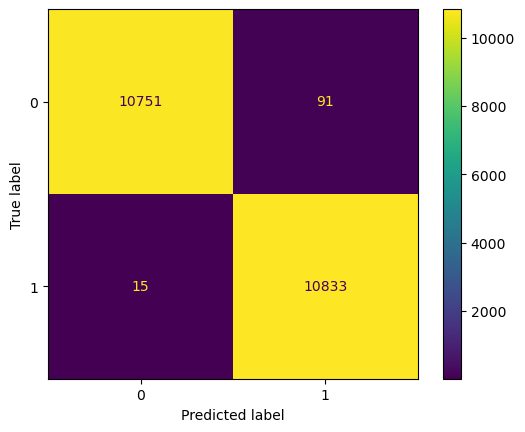

In [16]:
if STATIC_SPLIT > 0:
    y_pred = ib_catb.predict(X_ib_validate)
    print("CATB_IB")
    print(classification_report(y_ib_validate, y_pred, digits=4))
    print("AUC-ROC:", roc_auc_score(y_ib_validate, y_pred))
    print(classification_report(y_ib_validate, y_pred, digits=4), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB_ClassReport.txt", mode='w'))
    print("AUC-ROC:", roc_auc_score(y_ib_validate, y_pred), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB_ClassReport.txt", mode='a'))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_ib_validate, y_pred))
    disp.plot()
    plt.savefig("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB_"+"_ConfMatrix.png")

### 2.3.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

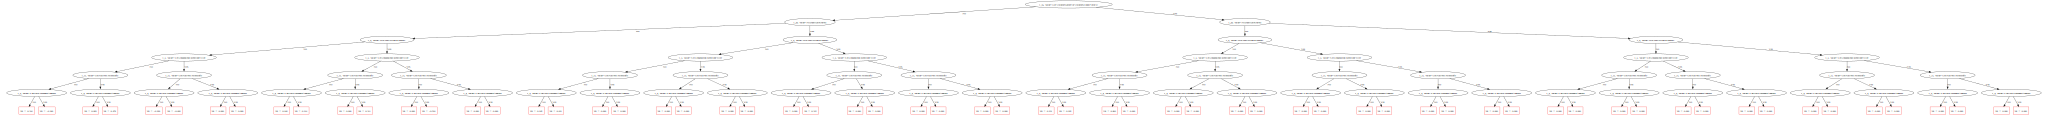

In [17]:
tree = ib_catb.plot_tree(0, catboost.Pool(X_ib_training, y_ib_training, cat_features=get_indexes(), feature_names=list(X_ib_training.columns)))
tree.save("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TREE/IB_Tree_0"+".svg")
display(tree)

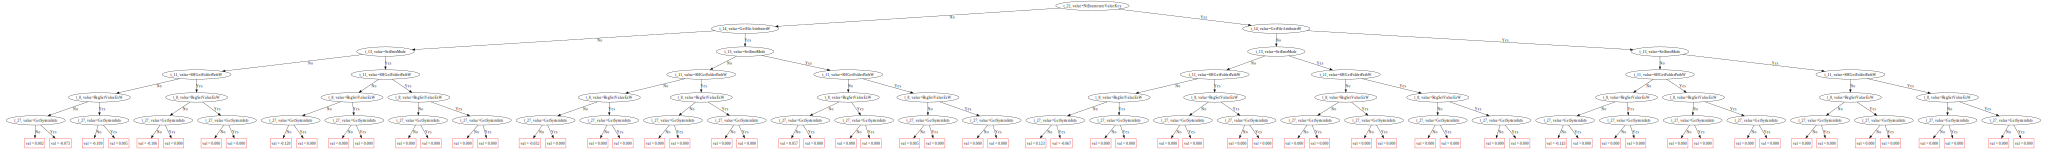

In [18]:
tree = ib_catb.plot_tree(int((ib_catb.get_best_iteration()-1)/2), catboost.Pool(X_ib_training, y_ib_training, cat_features=get_indexes(), feature_names=list(X_ib_training.columns)))
tree.save("Outputs/CATB/"+MODEL_FILENAME+f"_CATB_TREE/IB_Tree_{int((ib_catb.get_best_iteration()-1)/2)}"+".svg")
display(tree)

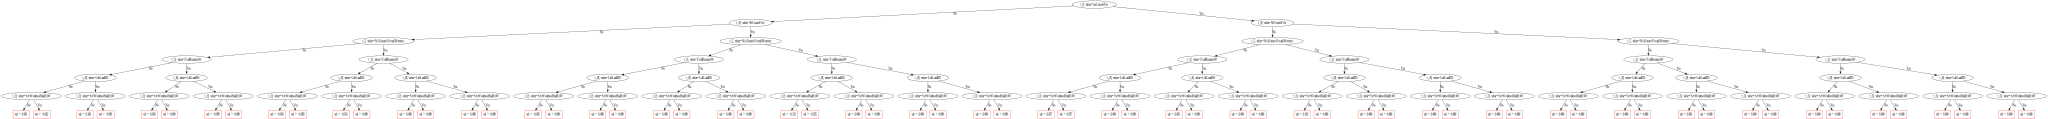

In [19]:
tree = ib_catb.plot_tree(int((ib_catb.get_best_iteration()-1)), catboost.Pool(X_ib_training, y_ib_training, cat_features=get_indexes(), feature_names=list(X_ib_training.columns)))
tree.save("Outputs/CATB/"+MODEL_FILENAME+f"_CATB_TREE/IB_Tree_{int((ib_catb.get_best_iteration()-1))}"+".svg")
display(tree)

In [20]:
logging("\n")